In [1]:
library(readxl)
library(timedeppar)
library(gridExtra)
library(grid)

Loading required package: mvtnorm



# Functions

In [2]:
initialize_dataframes <- function() {
    harmonics_cols <- c("Period", "dPeriod", "Amplitude", "dAmplitude", 
              "Phase", "dPhase")
    obs_cols <- c("Age", "d18o")
    
    # load dataframes
    if (is.na(table_stal_harmonics)) {
        table_stal_harmonics <- "stalagmites_10ky_harmonics_original.xlsx"
    }
    if (is.na(table_ice_harmonics)) {
        table_ice_harmonics <- "icecores_30ky_harmonics_original.xlsx"
    }
    
    stal_harmonics <- suppressWarnings(read_excel(paste0("data/", table_stal_harmonics), 
                                                  skip = 1, col_names = harmonics_cols, 
                                                  col_types = "numeric"))

    d18o_harmonics <- suppressWarnings(read_excel(paste0("data/", table_ice_harmonics), 
                                                  skip = 1, col_names = harmonics_cols, 
                                                  col_types = "numeric"))

    d18o_raw_tot <- suppressWarnings(read_excel(paste0("data/", "icecores_30ky_raw_original.xlsx"), 
                                                skip = 1, col_names = obs_cols, 
                                                col_types = "numeric"))
    
    # center raw d18o data and keep just first N years
    years_from_now <- d18o_raw_tot$Age - d18o_raw_tot$Age[1]
    d18o_raw_tot$Age <- years_from_now
    first30ky <- d18o_raw_tot[years_from_now <= n_years,]
    first30ky["d18o"] <- first30ky$d18o - mean(first30ky$d18o)
    d18o_raw <- first30ky[first30ky$Age <= n_years,]
    
    # add new columns
    d18o_harmonics$Omega <- numeric(nrow(d18o_harmonics))
    d18o_harmonics$dOmega <- numeric(nrow(d18o_harmonics))
    d18o_harmonics$FixedOmega <- rep(FALSE, nrow(d18o_harmonics))
    
    # identify reference omegas
    cat("Fixed harmonics:\n")
    for (i in 1:nrow(d18o_harmonics)) {
        for (j in 1:nrow(stal_harmonics)) {
            d18o_period <- d18o_harmonics$Period[i]
            stal_period <- stal_harmonics$Period[j]
            
            # calculate relative difference
            rel_diff <- abs(d18o_period - stal_period) / stal_period
            if (rel_diff <= 3/100) {
                d18o_harmonics$FixedOmega[i] <- TRUE
                d18o_harmonics$Period[i] <- stal_harmonics$Period[j]
                d18o_harmonics$dPeriod[i] <- stal_harmonics$dPeriod[j]
                cat("\nStal. period: ", stal_period, ", d18O period: ", d18o_period, sep="")
            }
        }
    }
    
    # calculate values of Omega and dOmega
    d18o_harmonics$Omega <- 2 * pi / d18o_harmonics$Period
    d18o_harmonics$dOmega <- 2 * pi * d18o_harmonics$dPeriod / d18o_harmonics$Period^2
    
    # return all the dataframes
    list(
        stal_harmonics = stal_harmonics,
        d18o_harmonics = d18o_harmonics,
        d18o_raw = d18o_raw
    )
    
}

initialize_params <- function(dfs, sigma_d18o=1, gamma=15) {
    # TODO: change sigma_d18o
    
    harmonics <- dfs$d18o_harmonics
    params_names <- c()
    
    raw <- dfs$d18o_raw
    time_diffs <- diff(raw$Age)
    
    # define parameters properties
    param.ini <- list()
    param.ou.ini <- c()
    param.range <- list()
    param.log <- c()
    
    # add harmonics' free parameters to "param.ini"
    for (i in 1:nrow(harmonics)) {
        names <- paste0(c("Amplitude", "Phase", "Period"), i)
        
        A <- harmonics$Amplitude[i]
        param.ini[[names[1]]] <- A
        param.ini[[names[2]]] <- harmonics$Phase[i]
        if (!harmonics$FixedOmega[i]) {
            param.ini[[names[3]]] <- harmonics$Period[i]
        }
        
        param.range[[names[1]]] <- c(A - harmonics$dAmplitude[i], A + harmonics$dAmplitude[i])
        param.range[[names[2]]] <- c(0, 2*pi)
        if (!harmonics$FixedOmega[i]) {
            param.range[[names[3]]] <- harmonics$Period[i] * c(0.97, 1.03)
        } else {
            names <- paste0(c("Amplitude", "Phase"), i)
        }
        
        params_names <- c(params_names, names)
        
    }
    param.ini$xi <- cbind(
        t = raw$Age[-nrow(raw)],
        y = time_diffs
    )
    param.ini$sigma_d18o <- sigma_d18o
    
    # add xi parameters to "param.ou.ini"
    param.ou.ini <- c( mean(time_diffs), sd(time_diffs), gamma)
    names(param.ou.ini) <- c("xi_mean", "xi_sd", "xi_gamma")
    
    # ranges
    param.range$sigma_d18o = c(0.01, 10)
    param.range$xi_sd = c(0.01, 10) # TODO: change values
    param.range$xi_gamma = c(1, 20)
    
    # for all free parameters set whether to infer in log-space or not
    param.log <- c(rep(FALSE, length(params_names)+3), TRUE)
    names(param.log) <- c(params_names, "xi", "xi_sd", "xi_gamma", "sigma_d18o")
    
    list(
        ini = param.ini,
        ou.ini = param.ou.ini,
        range = param.range,
        log = param.log
    )
}

log_likelihood <- function(params, data) {
    # build the model from current parameters
    model <- build_model(data, params)$y
    
    # feedback
    count <<- count + 1
    current_percent <- as.integer(100 * count / max_count)
    
    if (current_percent > percent) {        
        # draw percent bar
        percent <<- current_percent
        filled <- floor(percent / 2)
        spaces <- max(0, 50 - filled - 1)
        
        bar <- c(rep("█", filled), rep("░", spaces))
        cat(paste0("\r", paste(bar, collapse = ""), 
                   "  ", current_percent, "%"))
        
        flush.console()
    }
    
    # return the log-likelihood of the observed data
    sum(dnorm(data$d18o, mean = model, 
              sd = params$sigma_d18o, log=TRUE))
}

logprior <- function(params) {    
    harmonics <- dataframes$d18o_harmonics
    ix <- 1:nrow(harmonics)
    
    res <- 0
    for (param_name in c("Amplitude", "Period", "Phase")) {
        if (param_name == "Period") {
            ix <- ix[!(harmonics$FixedOmega)]
        }
        
        param0 <- harmonics[[param_name]][ix]
        param <- params[paste0(param_name, ix)]
        if (param_name == "Period") {
            param <- params[paste0(param_name, ix)]
        }
        dparam <- harmonics[[paste0("d", param_name)]][ix]
        if (param_name == "Phase") {
            dparam <- rep(0.1, length(ix))
        }
        
        res <- res + sum(dnorm(param, mean = param0, 
                               sd = dparam, log = TRUE))
    }
    return(res)
}

run_inference <- function(dfs, params) {    
    percent <<- 0
    count <<- 0
    max_count <<- n_iter * (n_interval + 1)
    
    raw <- dfs$d18o_raw
    
    res <- infer.timedeppar(
        loglikeli = log_likelihood,
        data = raw,
        param.ini = params$ini,
        param.ou.ini = params$ou.ini,
        param.log = params$log,
        param.range = params$range,
        param.logprior = logprior,
        verbose = 0,
        n.iter = n_iter,
        control = list(
            n.interval = n_interval,
            n.adapt = floor(0.4 * n_iter)
        )
    )
    
    # plot(res, type = c("traces", "time-series"))
    return(res)
}

build_model <- function(raw, params=NA) {
    harmonics <- dataframes$d18o_harmonics
    
    times <- raw$Age
    if (!sum(is.na(params))) {
        xi <- params$xi[,2]
        times <- c(raw$Age[1], raw$Age[1] + cumsum(xi))
    }
    
    model <- numeric(length(times))
    for (i in 1:nrow(harmonics)) {
        amplitude <- harmonics$Amplitude[i]
        phase <- harmonics$Phase[i]
        omega <- 2 * pi / harmonics$Period[i]
        
        if (!sum(is.na(params))) {
            amplitude <- params[[paste0("Amplitude", i)]]
            phase <- params[[paste0("Phase", i)]]
            if (!harmonics$FixedOmega[i]) {
                omega <- 2 * pi / params[[paste0("Period", i)]]
            }
        }

        model <- model + amplitude * cos(omega * times + phase)
    }
    
    return(list(x=times, y=model))
}

In [3]:
compare_results <- function(res) {
    # init
    df_before <- build_model(dataframes$d18o_raw)
    df_after <- build_model(dataframes$d18o_raw, res$param.maxpost)

    table_name <- ""
    if (is.na(table_stal_harmonics)) {
        table_name <- "stal_original"
    } else {
        table_name <- unlist(strsplit(table_stal_harmonics, "\\."))[1]
    }
    
    if (is.na(table_ice_harmonics)) {
        table_name <- paste0(table_name, "+icecores_original")
    } else {
        table_name <- paste0(table_name, "+", unlist(strsplit(table_ice_harmonics, "\\."))[1])
    }

    path <- file.path("images", paste0(n_iter, " iter"), paste0(n_years, " years"))
    dir.create(path, recursive = TRUE, showWarnings = FALSE)

    if (save_plots) {
        filename <- file.path(path, paste0(table_name, ".pdf"))
        pdf(filename, width = 10, height = 6)
    }

    plot_time_series(res)
    add_posterior_table(res)
    
    plot_comparison(dataframes$d18o_raw, df_before, df_after)
    plot_time_difference(res$sample.param.timedep$xi)

    if (save_plots) dev.off()
}

plot_comparison <- function(raw_data, before, after, data_lw=0.5, fit_lw=2.5, col_before="firebrick1",
                            col_after="steelblue", xlim=NULL) {
    
    # 1
    plot(raw_data,
         main = "Bayesian Harmonic Fit",
         type = "l", lwd = data_lw,
         xlim = xlim
    )
    lines(before,
          col = col_before, lwd = fit_lw
    )
    lines(after,
          col = col_after, lwd = fit_lw
    )
    legend("topleft",
           legend=c("Original data", "Bayesian fit before", "Bayesian fit after"),
           lty=c(1, 1, 1),
           lwd=c(data_lw, fit_lw, fit_lw),
           col=c(1, col_before, col_after),
           #inset = c(-0.05, 0)
    )
    grid()

    # 2
    plot(raw_data,
         main = "Original Fit",
         type = "l", lwd = data_lw,
         xlim = xlim
    )
    lines(before,
          col = col_before, lwd = fit_lw
    )
    grid()

    # 3
    plot(raw_data,
         main = "Inferred Fit",
         type = "l", lwd = data_lw,
         xlim = xlim
    )
    lines(after,
          col = col_after, lwd = fit_lw
    )
    grid()
}

plot_time_difference <- function(xi, fit_lw=2.5) {
    t1 <- cumsum(c(0, colMeans(xi[-1,])))
    t1 <- t1[1:(length(t1)-1)]
    # plot(xi[1,], new_t[1:(length(new_t)-1)]-xi[1,], type="l")-xi[1,]
    
    #xi_final <- xi[nrow(xi),]
    t0 <- xi[1,]
    #t1 <- c(0, cumsum(xi_final[1:(length(xi_final)-1)]))
    
    plot(t1, t1 - t0, 
         type = "l", lwd = fit_lw, col = "mediumseagreen",
         xlab = "Age", ylab = "Difference in time values",
         main = "Time difference (Delta t vs t)"
    )
    grid()
}

plot_time_series <- function(res) {    
    plot(res, type = c("traces", "time-series"))
}

add_posterior_table <- function(res){
    harmonics <- dataframes$d18o_harmonics
    params_post <- res$param.maxpost
    cols <- c("Period", "dPeriod", "Amplitude", "dAmplitude", "Phase", "dPhase", "FixedOmega")

    # 1)
    df <- round(harmonics[,cols], 2)
    names(df)[names(df)=="FixedOmega"] <- "FixedPeriod"
    
    grid.newpage()
    grid.text("Harmonics before", x = 0.5, y = 0.95, gp = gpar(fontsize = 16, fontface = "bold"))
    grid.draw(tableGrob(df))

    # 2)
    periods <- c()
    amplitudes <- c()
    phases <- c()
    for (i in 1:nrow(harmonics)) {
        A <- params_post[[paste0("Amplitude", i)]]
        Phi <- params_post[[paste0("Phase", i)]]
        
        amplitudes <- c(amplitudes, A)
        phases <- c(phases, Phi)
    
        if (harmonics$FixedOmega[i]) {
            periods <- c(periods, harmonics$Period[i])
        } else {
            periods <- c(periods, params_post[[paste0("Period", i)]])
        }
    }
    
    new_params <- data.frame(
        Period = periods,
        Amplitude = amplitudes,
        Phase = phases
    )

    grid.newpage()
    grid.text("Harmonics inferred", x = 0.5, y = 0.95, gp = gpar(fontsize = 16, fontface = "bold"))
    grid.draw(tableGrob(round(new_params, 2)))

    

    #grid.table(dataframes$d18o_harmonics)
    #grid.table(new_params)
}

In [9]:
n_years <- 10000
n_iter <- 10000
n_interval <- 25
save_plots <- FALSE

#table_stal_harmonics <- NA
table_stal_harmonics <- "stalagmites_10ky_harmonics_0601Fourier.xlsx"

#table_ice_harmonics <- "icecores_10ky_harmonics_0601Fourier.xlsx"
table_ice_harmonics <- "icecores_10ky_harmonics_0601LombScargle.xlsx"
#table_ice_harmonics <- "ice_cores_new.xlsx"

In [10]:
dataframes <- initialize_dataframes()
params <- initialize_params(dataframes)
res <- run_inference(dataframes, params)

Fixed harmonics:

Stal. period: 10718.38, d18O period: 10739.57

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          27

  number of time-dependent parameters:    1

  number of estimated process parameters: 3



█████████████████████████████████████████████████  98%

10000 iterations completed

  acceptance frequency of constant parameters:             0.321

  acceptance frequencies of time-dependent parameters:     0.816

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.203



plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,time-series



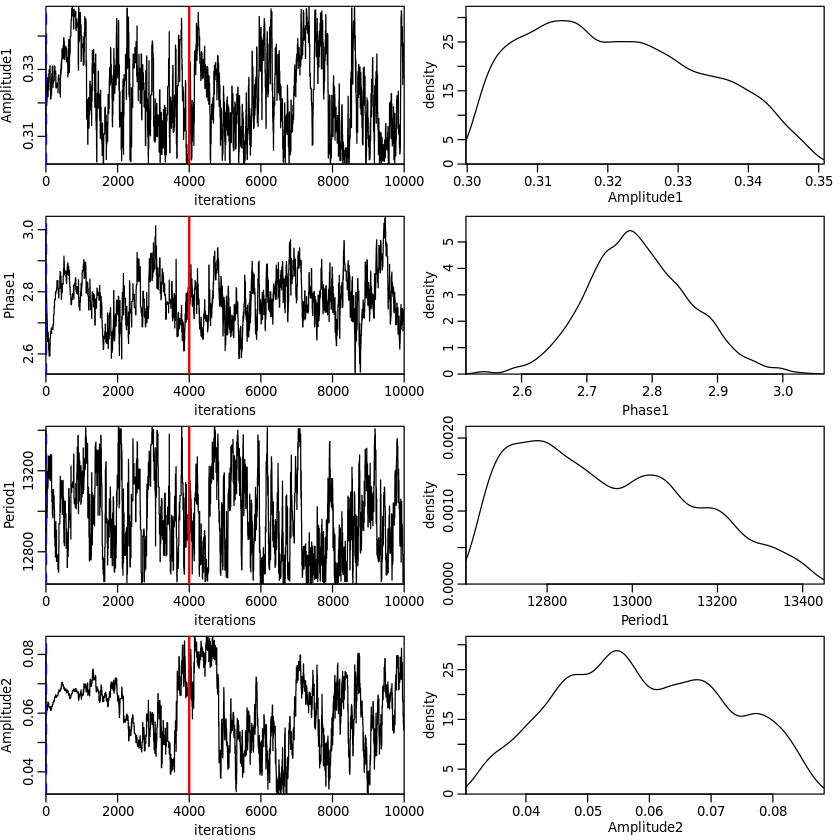

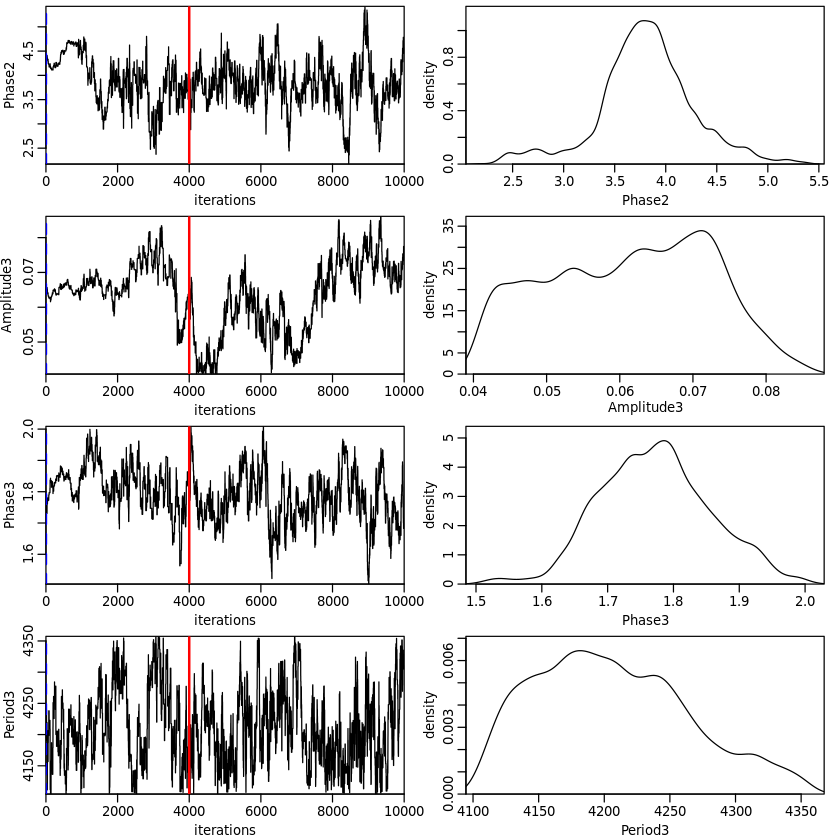

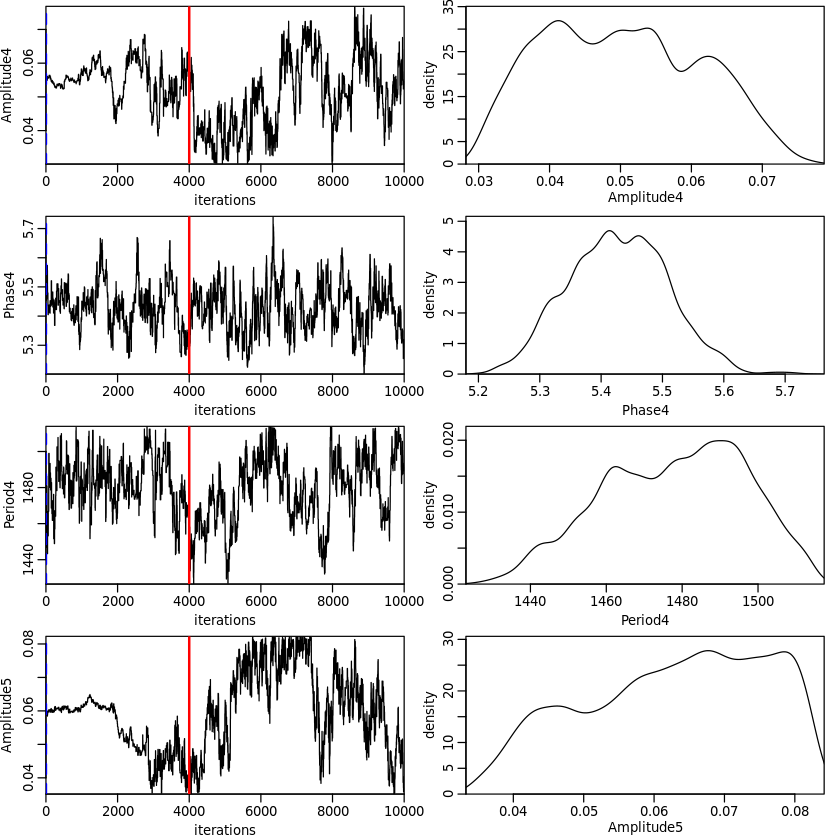

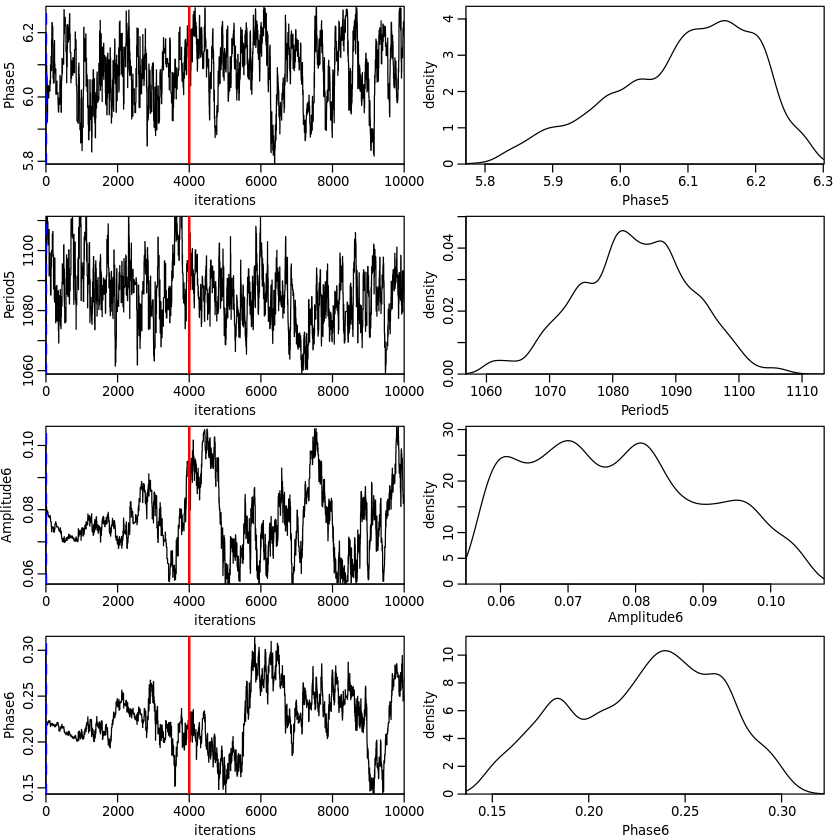

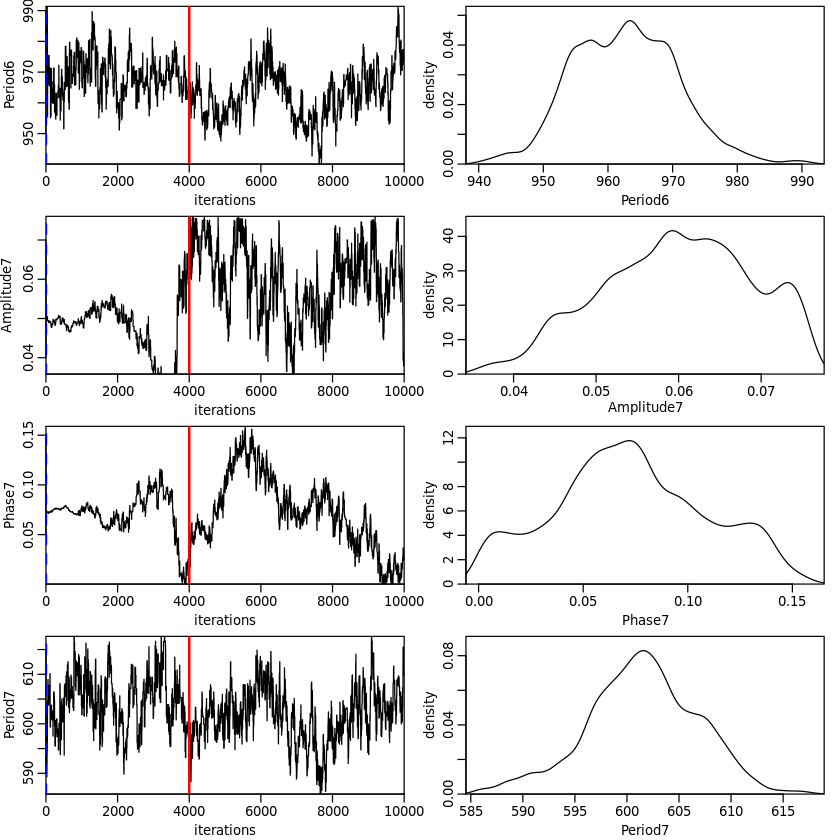

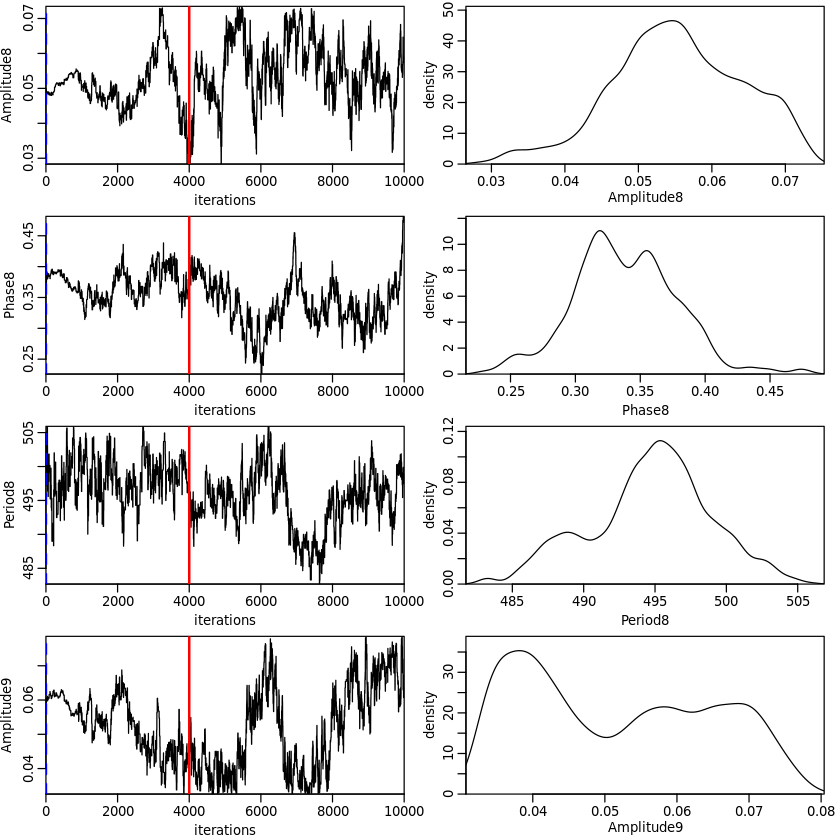

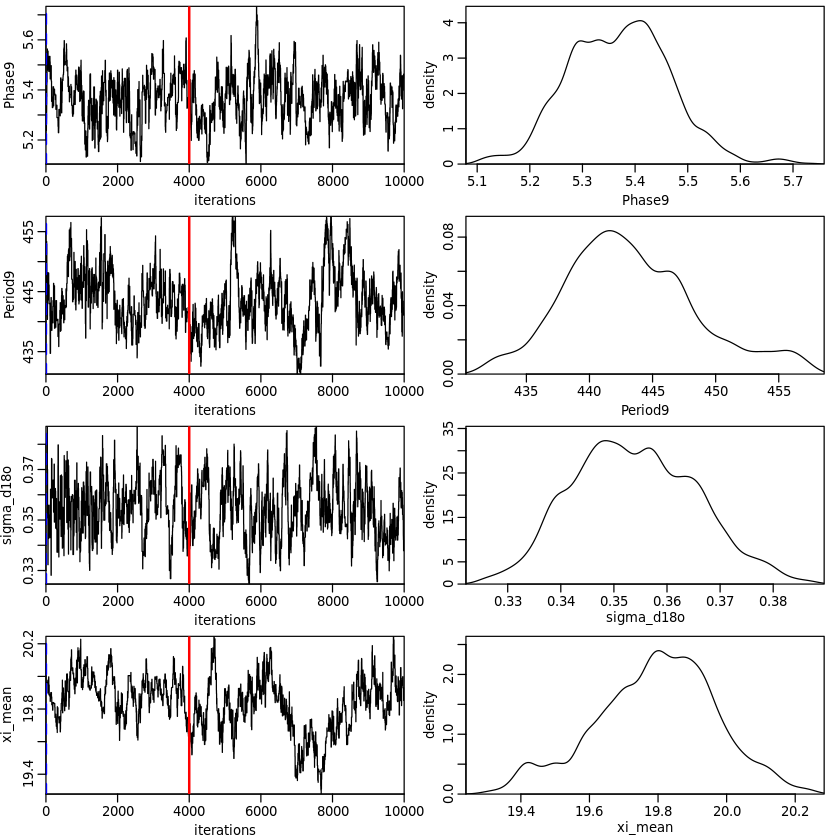

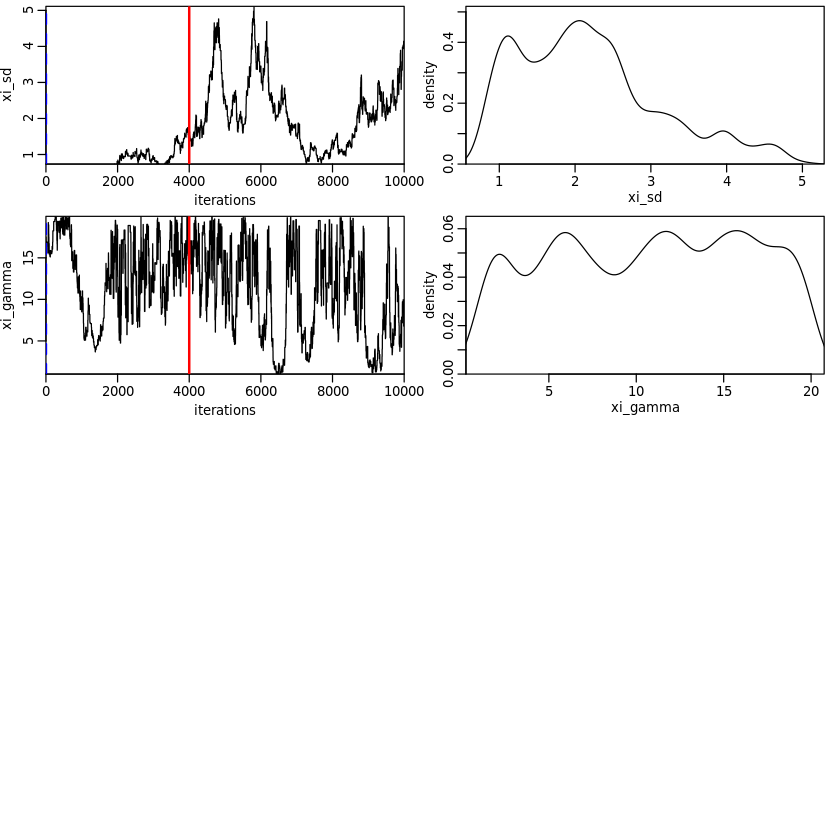

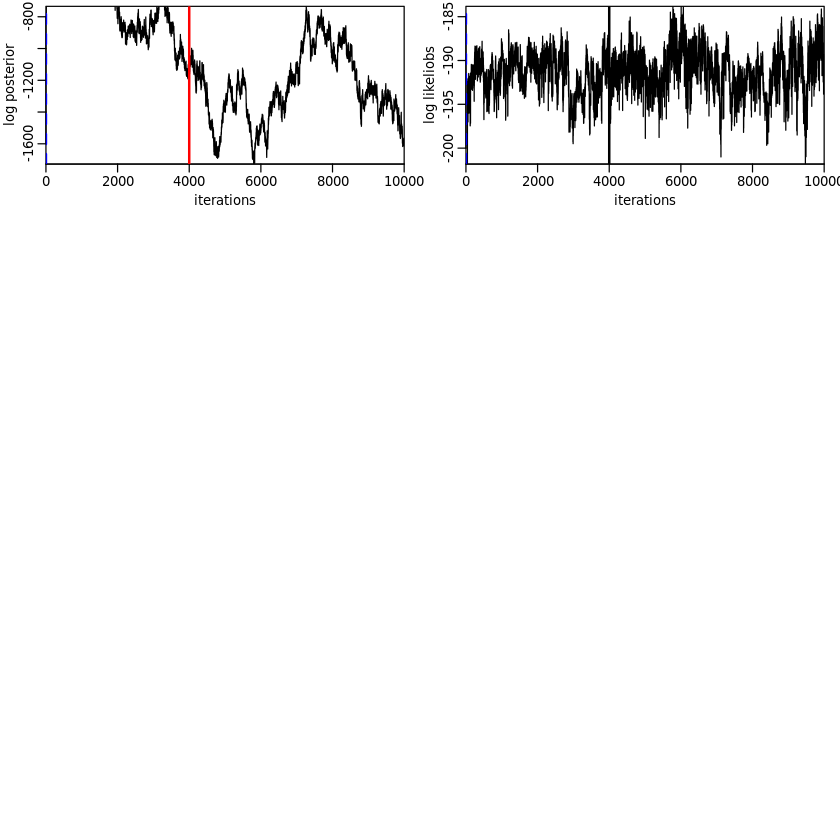

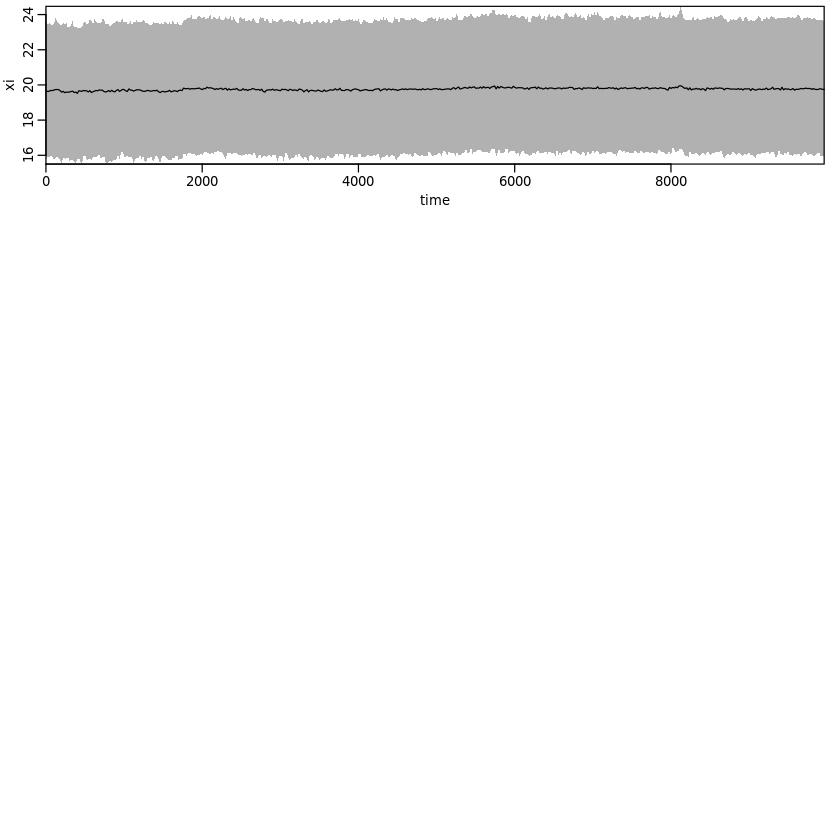

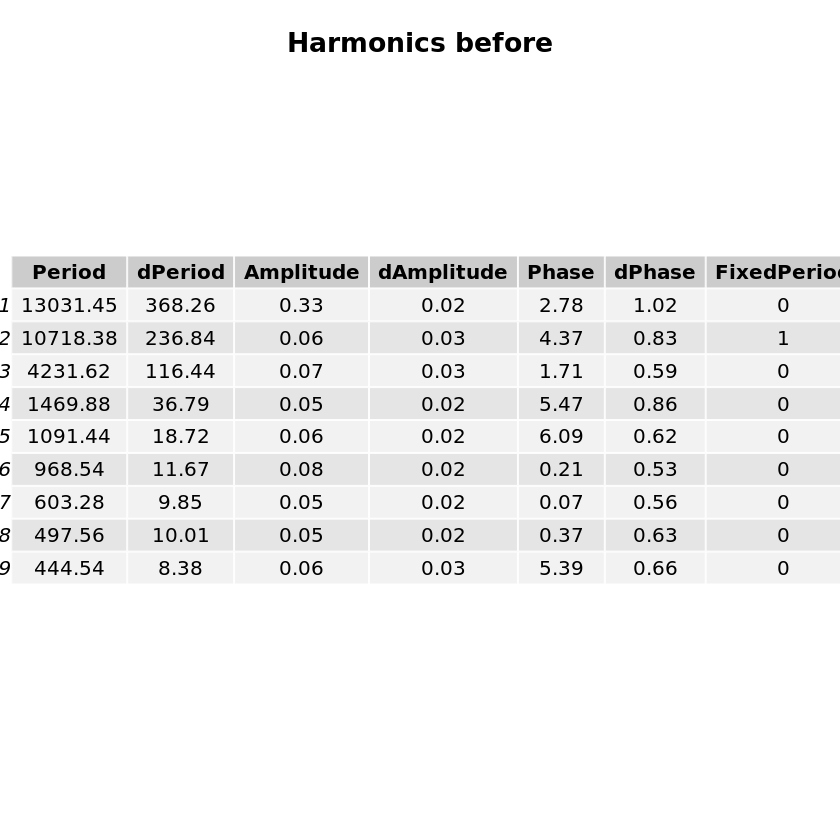

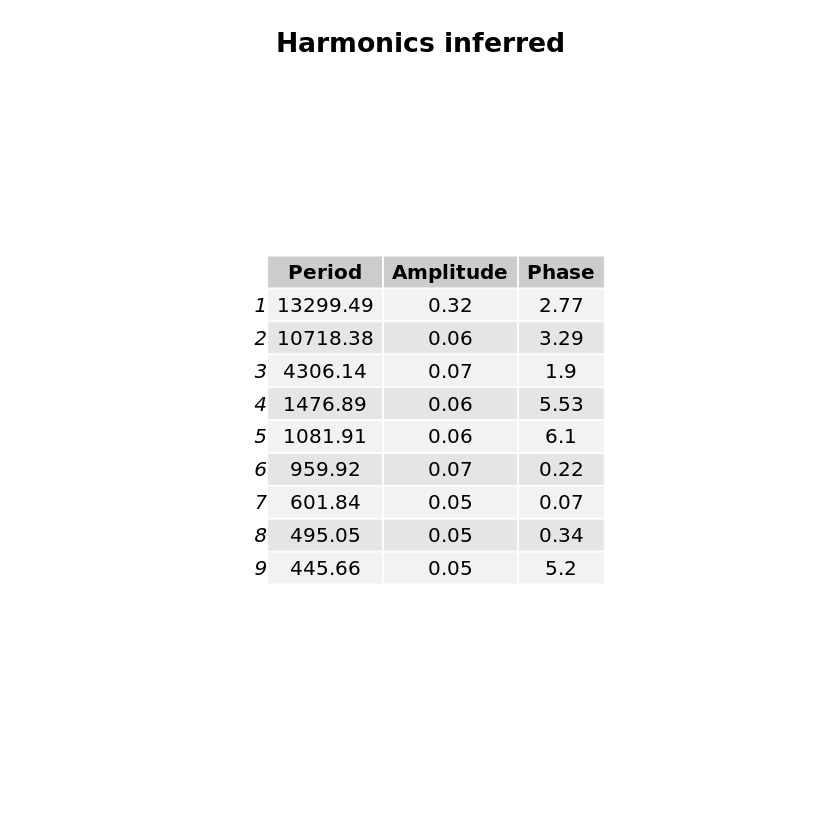

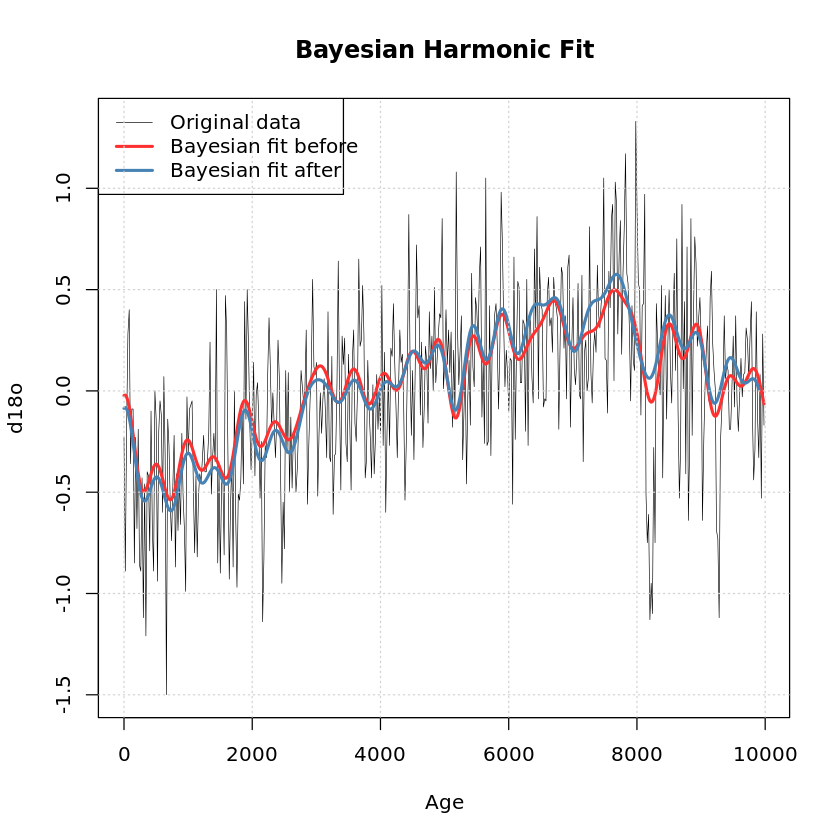

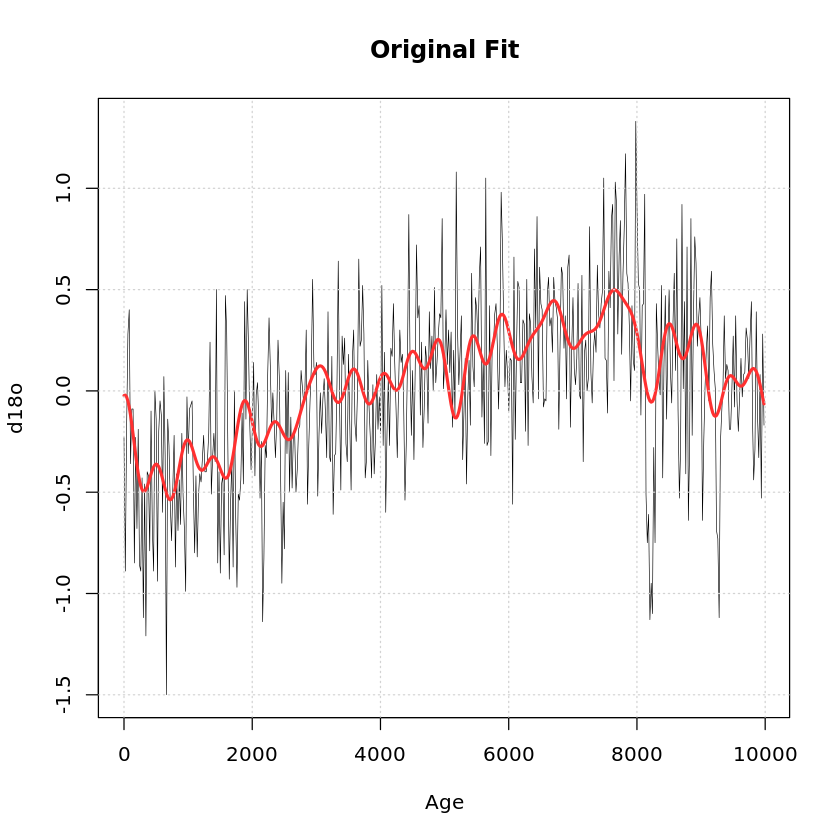

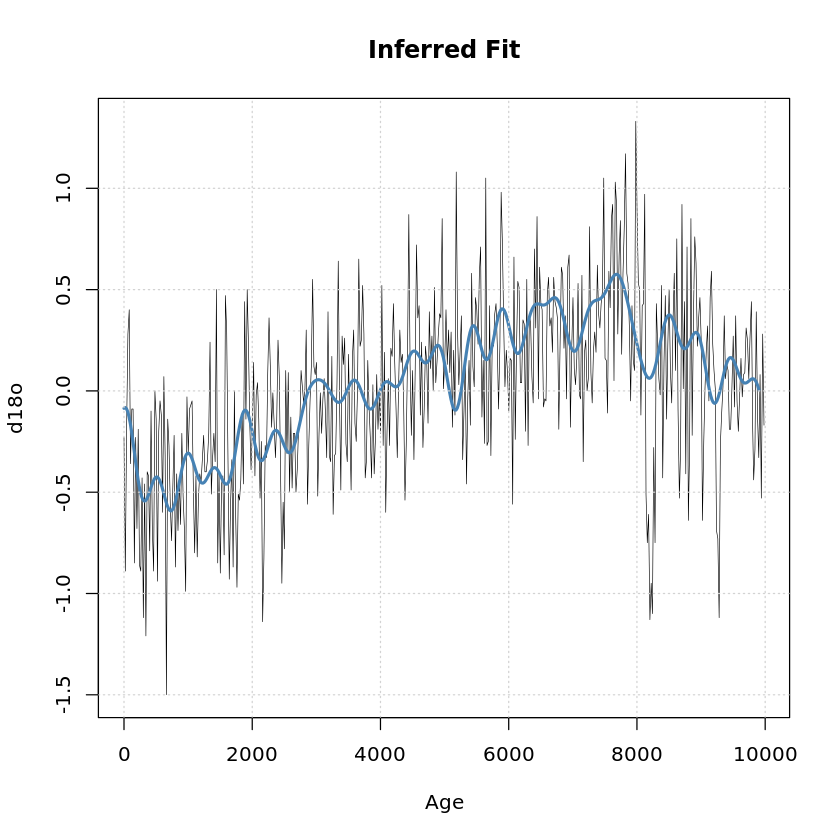

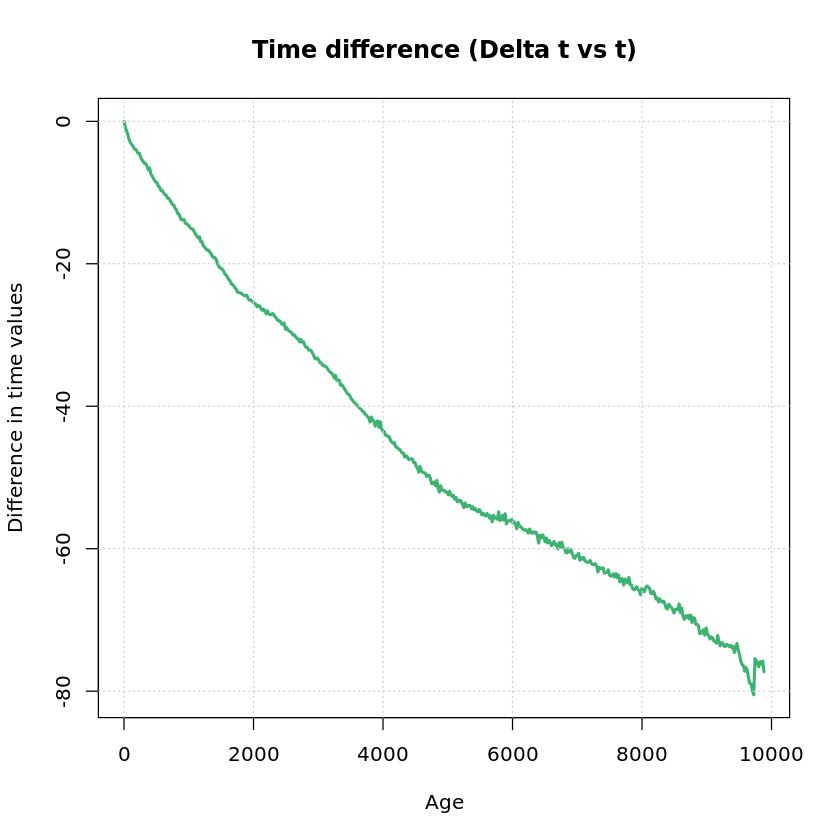

In [11]:
compare_results(res)

In [7]:
xi <- res$sample.param.timedep$xi
new_t <- cumsum(c(0, colMeans(xi[-1,])))
#plot(xi[1,], new_t[1:(length(new_t)-1)]-xi[1,], type="l")-xi[1,]

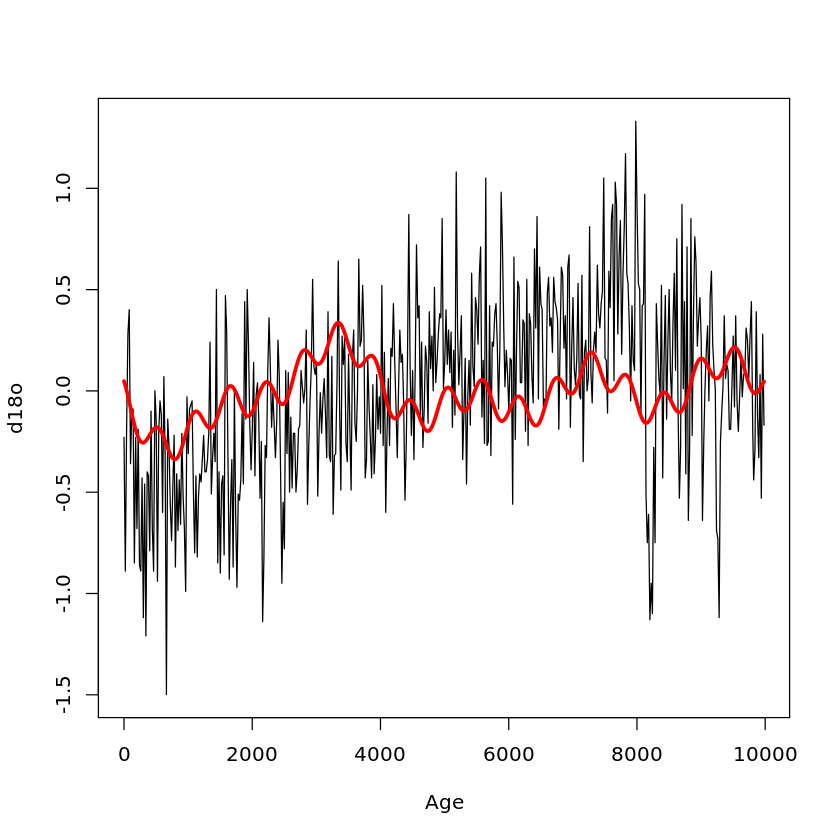

In [8]:
# using gripgicc
d <- dataframes$d18o_harmonics
y <- numeric(length(dataframes$d18o_raw$Age))
y2 <- numeric(length(dataframes$d18o_raw$Age))
for (i in 1:nrow(d)) {
    P <- d[i,]$Period
    A <- d[i,]$Amplitude
    Phi <- d[i,]$Phase
    y <- y + A * cos(2 * pi * dataframes$d18o_raw$Age / P + Phi)
    y2 <- y2 + A * sin(2 * pi * dataframes$d18o_raw$Age / P + Phi)
}
plot(dataframes$d18o_raw, type="l")
lines(dataframes$d18o_raw$Age, y, col="red", lwd=3)
#lines(dataframes$d18o_raw$Age, y2, col="blue", lwd=3)